# <font color = 'steelBlue'><b>SCC0276 — Aprendizado de Máquina</b></font>

## <font color = 'SlateGray'><b>Final Project</b></font>
---

<b>Authors:</b><br>
<b>João Vitor Pataca Beinotti</b><br>
<b>Murilo Henrique Gomes</br>

## <font color = 'steelBlue'><b>Bibliotecas e Funções:</b></font>

In [ ]:
# Bibliotecas utilizadas:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import gc
import time
import psutil
import ast

In [ ]:
# Funções utilizadas:
from google.colab import drive # comunicação entre colab e google drive
from zipfile import ZipFile

# Visualização e Manipuação de Imagens
from IPython.display import Image
from matplotlib.image import imread
from skimage.transform import resize
from skimage import color
from skimage import exposure

# Image Descriptors
from skimage.feature import hog

# Medida de desempenho
from tqdm import tqdm_notebook

In [ ]:
# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
# Funções construídas:

def calc_hog_features(file_path, pcc = 2):
  # acessando arquivo e abrindo em escala cinza
  img = cv.imread(file_path)
  grayimg = color.rgb2gray(img[:,:,::-1])
  del img

  # mudar dimensão da imagem
  resized_img = resize(grayimg, (128, 64))
  del grayimg

  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(pcc, pcc),
                    visualize=True,
                    multichannel=False)
  del resized_img
  del hog_image
  gc.collect()
  return fd

## <font color = 'steelBlue'><b>Base de Dados:</b></font>

### <font color = 'steelBlue'><b>Acesso aos Dados:</b></font>

In [ ]:
# Caminho para a base de dados:
path = 'path'

# Restringindo espaço de iteração aos arquivos .zip:
filesZIP = glob.glob(path + "*.zip")

# Iterando sob arquivos .zip e descomprimindo-os:
for file in filesZIP:
  zip = ZipFile(file)
  # extrair as pastas estarão no diretório raiz .../content/
  try:
    zip.extractall()
  except BadZipfile:
    continue
  except NotRarFile:
    continue

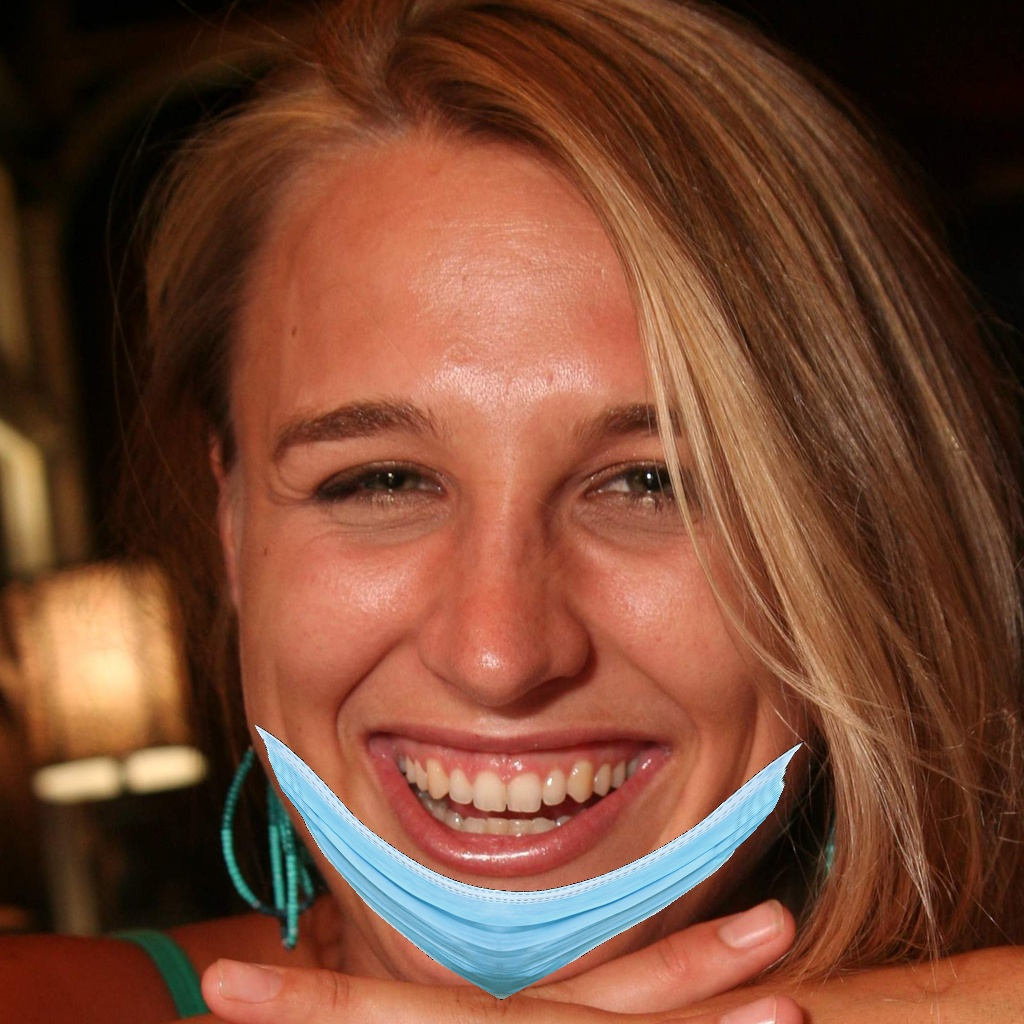

In [ ]:
Image("/content/00000/00001_Mask_Chin.jpg", width=250, height=250)

### <font color = 'steelBlue'><b>Estruturação:</b></font>

In [ ]:
# Acessando pastas
pastas = os.listdir('/content/')

# retirando pastas que não serão utilizadas:
pastas = [e for e in pastas if e not in ['.config', 'gdrive', 'sample_data'] ]

In [ ]:
all_data = [] # Matriz auxiliar
row = {} # Dicionario auxiliar

for pasta in pastas:
  arquivos = os.listdir('/content/' + pasta) # lista arquivos de cada pasta

  for img in arquivos: # itera sob a lista de arquivos

    # Atribuindo ao dicionario/linha os valores desejados
    row['Nome'] = img[:5] # código da imagem
    row['Classificacao'] = img[6:-4] # tipo de uso da máscara
    row['file_path'] = '/content/' + pasta + os.sep + img[:] # caminho da img

    # Atrivuindo dicionario/linha a matriz de dados.
    all_data.append(row)
    row = {} # limpando dados para proxima iteracao

In [ ]:
# Estruturando matriz de dados como pandas dataframe
dados = pd.DataFrame(all_data)
dados.head()

,Nome,Classificacao,file_path
0,03526,Mask,/content/03000/03526_Mask.jpg
1,03421,Mask,/content/03000/03421_Mask.jpg
2,03536,Mask_Mouth_Chin,/content/03000/03536_Mask_Mouth_Chin.jpg
3,03379,Mask,/content/03000/03379_Mask.jpg
4,03292,Mask_Mouth_Chin,/content/03000/03292_Mask_Mouth_Chin.jpg


In [ ]:
# Reordenando pelos nomes
dados = dados.sort_values(by = 'Nome')
dados

,Nome,Classificacao,file_path
21346,00000,Mask,/content/00000/00000_Mask.jpg
21844,00000,Mask_Mouth_Chin,/content/00000/00000_Mask_Mouth_Chin.jpg
21232,00001,Mask,/content/00000/00001_Mask.jpg
21898,00001,Mask_Mouth_Chin,/content/00000/00001_Mask_Mouth_Chin.jpg
21299,00001,Mask_Chin,/content/00000/00001_Mask_Chin.jpg
...,...,...,...
60607,69997,Mask,/content/69000/69997_Mask.jpg
59746,69998,Mask_Mouth_Chin,/content/69000/69998_Mask_Mouth_Chin.jpg
60878,69998,Mask,/content/69000/69998_Mask.jpg
59613,69999,Mask_Mouth_Chin,/content/69000/69999_Mask_Mouth_Chin.jpg


### <font color = 'steelBlue'><b>Análise Exploratória:</b></font>

In [ ]:
# Quais tipos de uso de mascara estão presentes:
dados['Classificacao'].unique()

array(['Mask', 'Mask_Mouth_Chin', 'Mask_Chin', 'Mask_Nose_Mouth'],
      dtype=object)

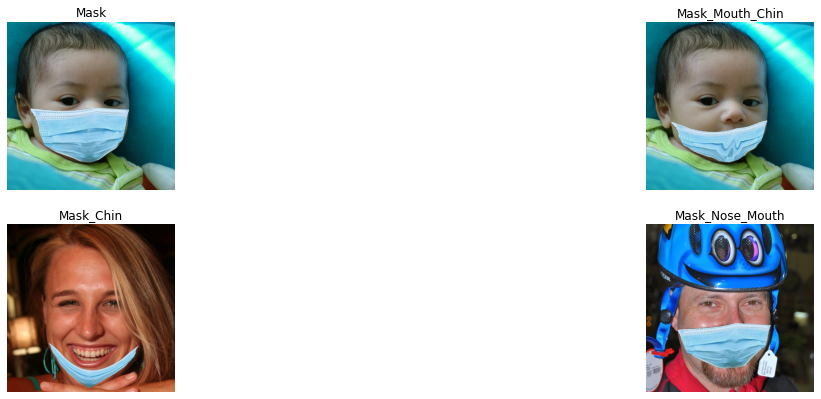

In [ ]:
# Visualizando exemplos:

# Amarzenando um exemplo de cada tipo:
exemplos = []
tipos = dados['Classificacao'].unique()

for item in tipos:
  exemplos.append(dados.loc[dados['Classificacao'] == item,'file_path'].iloc[0])

# Exibindo:

plt.figure(figsize=(21,10.5))
columns = 2
for i, image in enumerate(exemplos):
  ax = plt.subplot(len(exemplos) / columns + 1, columns, i + 1)
  ax.set_title(tipos[i])
  ax.set_axis_off()
  img = cv.imread(image)[:,:,::-1] # ler BGR em RGB
  plt.imshow(img)

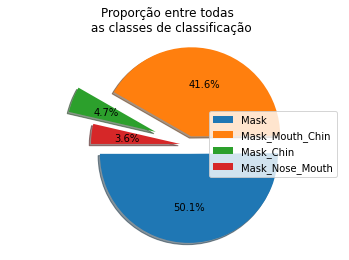

In [ ]:
# Balanceamento entre as classes:
# Visualização:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = dados['Classificacao'].unique()
sizes = dados['Classificacao'].value_counts()
explode = (0.1, 0.1, 0.4, 0.1)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()

fig1.suptitle("Proporção entre todas \n as classes de classificação")


ax1.pie(sizes, startangle= 180, autopct = '%1.1f%%',
                         explode = explode, shadow=True)
ax1.legend(labels, loc="center right")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Consideraremos a seguinte tabela para a classificação:
 <table>
  <tr>
    <th>Tipo de uso</th>
    <th>Correto</th>
    <th>Incorreto</th>
  </tr>
  <tr>
    <td>Mask</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>Mask_chin</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Mask_Mouth_Chin</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Mask_Nose_Mouth</td>
    <td>0</td>
    <td>1</td>
  </tr>
  
</table>

Sob a qual poderemos classificar as imagens sobre o seguinte critério de "<i>hot encolding</i>":

<table>
  </tr>
    <th>Classificação</th>
    <th>Valor</th>
  </tr>
  </tr>
    <td>Correto</td>
    <td>1</td>
  </tr>
  </tr>
    <td>Incorreto</td>
    <td>0</td>
  </tr>
</table>

In [ ]:
# Aplicando "hot encolding"
hot = {'Mask':1, 'Mask_Mouth_Chin':0, 'Mask_Chin':0, 'Mask_Nose_Mouth':0 }

dadosHot = dados.copy()
dadosHot.loc[:,'Classificacao'] = dados.loc[:,'Classificacao'].replace(hot)

In [ ]:
# Balanceamento dos dados:
dadosHot['Classificacao'].value_counts()

1    67048
0    66734
Name: Classificacao, dtype: int64

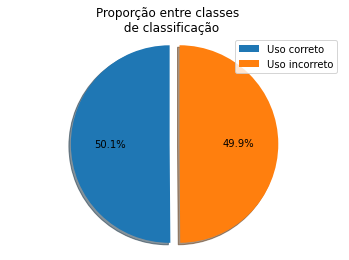

In [ ]:
# Visualização:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Uso correto', 'Uso incorreto']
sizes = dadosHot['Classificacao'].value_counts()
explode = (0, 0.1)  # only "explode" the 2nd slice

fig2, ax2 = plt.subplots()

fig2.suptitle("Proporção entre classes \n de classificação")


ax2.pie(sizes, startangle=90, autopct = '%1.1f%%',
                         explode = explode, shadow=True)
ax2.legend(labels, loc="best")
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## <font color = 'steelBlue'><b>Amostragem:</b></font>

A situação problema envolve o processamento de uma grande base de dados, por uma questão de limitações quanto a disponibilidade de memória RAM para a execução da extração e do treinamento dos dados, trabalharemos com uma amostra de 40 mil imagens. Teremos que garantir que tal sub conjunto de dados terá a mesma proporção entre as classes que o conjunto original.

In [ ]:
# Separando os casos corretos
mask = dados.loc[:,'Classificacao'] == 'Mask'

dados_mask = dados.loc[mask,:]

# Separando os casos incorretos:
mask_chin = dados.loc[:,'Classificacao'] == 'Mask_Chin'
mask_mouth_chin = dados.loc[:,'Classificacao'] == 'Mask_Mouth_Chin'
mask_nose_mouth = dados.loc[:,'Classificacao'] == 'Mask_Nose_Mouth'

dados_mask_chin = dados.loc[mask_chin,:]
dados_mask_mouth_chin = dados.loc[mask_mouth_chin,:]
dados_mask_nose_mouth = dados.loc[mask_nose_mouth,:]

sample_size = 30000

# Separaremos para o tamanho da amostra, respeitando a proporcao do dados originais
n_sample = int(sample_size*0.501)
sample_dados_mask = dados_mask.sample(n = n_sample)

n_sample = int(sample_size*0.047)
sample_dados_mask_chin = dados_mask_chin.sample(n = n_sample)

n_sample = int(sample_size*0.416)
sample_dados_mask_mouth_chin = dados_mask_mouth_chin.sample(n = n_sample)

n_sample = int(sample_size*0.036)
sample_dados_mask_nose_mouth = dados_mask_nose_mouth.sample(n = n_sample)

In [ ]:
dados_sample = pd.concat([sample_dados_mask, sample_dados_mask_chin
                        , sample_dados_mask_mouth_chin, sample_dados_mask_nose_mouth])

# Randomizando as linhas concatenadas para manter a organizacao do dataset original
dados_sample = dados_sample.sample(frac = 1)
dados_sample = dados_sample.reset_index(drop = True)

dados_sample.shape

(30000, 3)

## <font color = 'steelBlue'><b>Descritores de Imagem:</b></font>

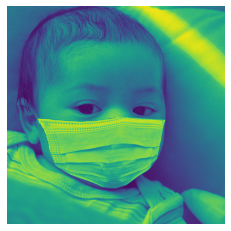

(1024, 1024)


In [ ]:
# HOG example
img = color.rgb2gray(cv.imread("/content/00000/00000_Mask.jpg")[:,:,::-1])
plt.imshow(img)
plt.axis('off')
plt.show()
print(img.shape)

(512, 256)


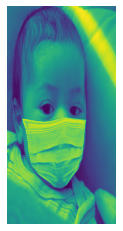

In [ ]:
resized_img = resize(img, (128*4, 64*4))
plt.axis("off")
plt.imshow(resized_img)
print(resized_img.shape)

In [ ]:
ppc = 16
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(ppc, ppc),
                    visualize=True,
                    multichannel=False)

In [ ]:
fd

array([0.00960368, 0.00529562, 0.00358393, ..., 0.00134759, 0.00325886,
       0.00217182])

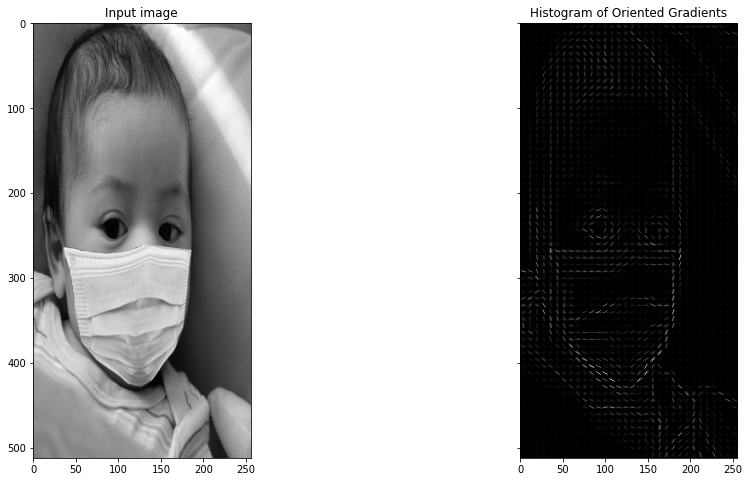

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.imshow(resized_img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

## <font color = 'steelBlue'><b>Extraindo Descritor de Imagem (HOG):</b></font>

In [ ]:
################## ----------------- Primeira parte ----------------- ##################

dados_sample_pt1 = dados_sample.iloc[0:20000,:]

In [ ]:
HOG_Features = [] # Matriz auxiliar
cont = 0

print('Percentage of RAM memory used before:', psutil.virtual_memory()[2])
inicio = time.time()
for path in tqdm_notebook(dados_sample_pt1.file_path, desc = 'tqdm() Progress Bar of folders'):
  # Atribuindo ao dicionario/linha os valores desejados
  #row['Nome'] = img[:5] # código da imagem
  aux = list(calc_hog_features(path))

  # Atribuindo dicionario/linha a matriz de dados.
  HOG_Features.append(aux)
  cont += 1

fim = time.time()
print('Tempo total de execução:', fim - inicio)
print('Percentage of RAM memory used after:', psutil.virtual_memory()[2])

Percentage of RAM memory used before: 15.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


tqdm() Progress Bar of folders:   0%|          | 0/20000 [00:00<?, ?it/s]

Tempo total de execução: 14611.268952608109
Percentage of RAM memory used after: 38.0


In [ ]:
dados_sample_pt1.loc[:,'HOG_Features'] = pd.Series(HOG_Features)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
# Encoding sample

hot = {'Mask':1, 'Mask_Mouth_Chin':0, 'Mask_Chin':0, 'Mask_Nose_Mouth':0 }

dadosHot_sample_pt1 = dados_sample_pt1.copy()
dadosHot_sample_pt1.loc[:,'Classificacao'] = dados_sample_pt1.loc[:,'Classificacao'].replace(hot)

In [ ]:
################## ----------------- Segunda parte ----------------- ##################

dados_sample_pt2 = dados_sample.iloc[20000:,:]

In [ ]:
HOG_Features_left = [] # Matriz auxiliar
cont = 0

print('Percentage of RAM memory used before:', psutil.virtual_memory()[2])
inicio = time.time()
for path in tqdm_notebook(dados_sample_pt2.file_path, desc = 'tqdm() Progress Bar of folders'):
  # Atribuindo ao dicionario/linha os valores desejados
  #row['Nome'] = img[:5] # código da imagem
  aux = list(calc_hog_features(path))

  # Atribuindo dicionario/linha a matriz de dados.
  HOG_Features_left.append(aux)
  cont += 1

fim = time.time()
print('Tempo total de execução:', fim - inicio)
print('Percentage of RAM memory used after:', psutil.virtual_memory()[2])

Percentage of RAM memory used before: 38.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


tqdm() Progress Bar of folders:   0%|          | 0/10000 [00:00<?, ?it/s]

Tempo total de execução: 13724.797227621078
Percentage of RAM memory used after: 49.2


In [ ]:
dados_sample_pt2 = dados_sample_pt2.reset_index(drop = True)
dados_sample_pt2.loc[:,'HOG_Features'] = pd.Series(HOG_Features_left)

In [ ]:
dados_sample_pt2

,Nome,Classificacao,file_path,HOG_Features
0,19538,Mask_Mouth_Chin,/content/19000/19538_Mask_Mouth_Chin.jpg,"[0.29201473594045935, 0.12427773736498435, 0.0..."
1,17077,Mask,/content/17000/17077_Mask.jpg,"[0.34033396374697694, 0.34033396374697694, 0.1..."
2,63865,Mask_Mouth_Chin,/content/63000/63865_Mask_Mouth_Chin.jpg,"[0.29639839582119115, 0.29639839582119115, 0.0..."
3,42029,Mask,/content/42000/42029_Mask.jpg,"[0.326299239028146, 0.07127950931990569, 0.068..."
4,13006,Mask,/content/13000/13006_Mask.jpg,"[0.2887043142049612, 0.0003537535827491897, 0...."
...,...,...,...,...
9995,45605,Mask_Mouth_Chin,/content/45000/45605_Mask_Mouth_Chin.jpg,"[0.35763899211692934, 0.03319176638444921, 0.0..."
9996,23450,Mask_Mouth_Chin,/content/23000/23450_Mask_Mouth_Chin.jpg,"[0.0588160499569507, 0.006050574275648222, 0.0..."
9997,01340,Mask,/content/01000/01340_Mask.jpg,"[0.22404489641869682, 0.03925468715745845, 0.2..."
9998,10223,Mask,/content/10000/10223_Mask.jpg,"[0.22106131241281976, 0.0, 0.0, 0.0, 0.0512822..."


In [ ]:
hot = {'Mask':1, 'Mask_Mouth_Chin':0, 'Mask_Chin':0, 'Mask_Nose_Mouth':0 }

dadosHot_sample_pt2 = dados_sample_pt2.copy()
dadosHot_sample_pt2.loc[:,'Classificacao'] = dados_sample_pt2.loc[:,'Classificacao'].replace(hot)

In [ ]:
df_final = pd.concat([dadosHot_sample_pt1, dadosHot_sample_pt2])

df_final = df_final.reset_index(drop = True)
df_final.shape

(30000, 4)

In [ ]:
df_final

,Nome,Classificacao,file_path,HOG_Features
0,67688,0,/content/67000/67688_Mask_Chin.jpg,"[0.3412657363691528, 0.12764162859237227, 0.01..."
1,18163,1,/content/18000/18163_Mask.jpg,"[0.34050498837969095, 0.22270707504210377, 0.0..."
2,39390,0,/content/39000/39390_Mask_Mouth_Chin.jpg,"[0.28671383218445873, 0.28671383218445873, 0.0..."
3,48466,0,/content/48000/48466_Mask_Mouth_Chin.jpg,"[0.07077355332589583, 0.0013742799837973207, 0..."
4,15752,1,/content/15000/15752_Mask.jpg,"[0.16203754189561084, 0.0, 0.02713307917470425..."
...,...,...,...,...
29995,45605,0,/content/45000/45605_Mask_Mouth_Chin.jpg,"[0.35763899211692934, 0.03319176638444921, 0.0..."
29996,23450,0,/content/23000/23450_Mask_Mouth_Chin.jpg,"[0.0588160499569507, 0.006050574275648222, 0.0..."
29997,01340,1,/content/01000/01340_Mask.jpg,"[0.22404489641869682, 0.03925468715745845, 0.2..."
29998,10223,1,/content/10000/10223_Mask.jpg,"[0.22106131241281976, 0.0, 0.0, 0.0, 0.0512822..."


## <font color = 'steelBlue'><b>Modelos:</b></font>

In [ ]:
df_final = pd.read_csv('path')

df_final = df_final.convert_dtypes()
df_final.HOG_Features = df_final.HOG_Features.apply(ast.literal_eval)

In [ ]:
X = np.stack(df_final.HOG_Features.values)

In [ ]:
Y = df_final.loc[:,'Classificacao'].to_numpy()

# Caso ler do csv
Y = Y.astype('int')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=42)

## KNN

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=7)

# KNN.fit(X_train, Y_train)
# print(KNN.score(X_train, Y_train))

# y_pred = KNN.predict(X_test)
# print('ACCURACY SCORE: ', accuracy_score(Y_test, y_pred))

In [ ]:
# Hiperparametros
parametros = {'n_neighbors': [1, 3, 5, 7, 11],
              'weights': ['uniform', 'distance']}

# Métrica escolhida (AUC)
score = {'AUC':make_scorer(roc_auc_score),
         'ACCURACY':make_scorer(accuracy_score)}

In [ ]:
inicio = time.time()
grid_3fold = GridSearchCV(estimator = KNN,
                    param_grid = parametros,   # Dicionário com valores para serem testados.
                    scoring = score,
                    refit = 'ACCURACY',
                    cv = 3)                   # 3-fold cross-validation.

grid_3fold.fit(X_train, Y_train)
fim = time.time()
print('Tempo total de execução:', fim - inicio)

Tempo total de execução: 934.9959177970886


In [ ]:
df_knn = pd.DataFrame(grid_3fold.cv_results_)
df_knn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_ACCURACY,split1_test_ACCURACY,split2_test_ACCURACY,mean_test_ACCURACY,std_test_ACCURACY,rank_test_ACCURACY
0,0.352376,0.104833,30.628679,1.011410,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.840813,0.833517,0.836519,0.836950,0.002994,9,0.840875,0.833625,0.836625,0.837042,0.002974,9
1,0.275335,0.004003,29.629802,0.050949,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.840813,0.833517,0.836519,0.836950,0.002994,9,0.840875,0.833625,0.836625,0.837042,0.002974,9
2,0.276933,0.005059,31.151414,1.214301,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.961159,0.958141,0.952523,0.957274,0.003578,6,0.961250,0.958250,0.952625,0.957375,0.003575,6
3,0.273879,0.005156,30.116503,0.028922,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.924667,0.921264,0.917767,0.921233,0.002817,8,0.924750,0.921375,0.917875,0.921333,0.002807,8
4,0.278564,0.008390,31.146727,0.063881,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.966407,0.965399,0.960395,0.964067,0.002629,3,0.966500,0.965500,0.960500,0.964167,0.002625,3
5,0.271909,0.003745,31.557299,1.033440,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.960280,0.957774,0.952389,0.956814,0.003292,7,0.960375,0.957875,0.952500,0.956917,0.003286,7
6,0.271643,0.003042,31.066502,0.127927,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.968284,0.966650,0.962269,0.965734,0.002540,1,0.968375,0.966750,0.962375,0.965833,0.002534,1
7,0.296438,0.036372,30.804264,0.070635,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.965281,0.962897,0.958392,0.962190,0.002857,5,0.965375,0.963000,0.958500,0.962292,0.002851,5
8,0.272146,0.003418,30.989059,0.083389,11,uniform,"{'n_neighbors': 11, 'weights': 'uniform'}",0.968529,0.964142,0.963270,0.965314,0.002302,2,0.968625,0.964250,0.963375,0.965417,0.002297,2
9,0.275213,0.005038,31.426444,0.811332,11,distance,"{'n_neighbors': 11, 'weights': 'distance'}",0.967275,0.963265,0.961020,0.963853,0.002587,4,0.967375,0.963375,0.961125,0.963958,0.002585,4


In [ ]:
grid_3fold.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [ ]:
grid_3fold.best_score_

0.9658333333333333

In [ ]:
# pred_prob = grid_3fold.predict_proba(X_test)
# prob = pred_prob[:, 1]

# score = roc_auc_score(Y_test, prob)
# score

### SVM

In [ ]:
SVC = SVC(random_state = 42)

# SVC.fit(X_train, Y_train)
# print(SVC.score(X_train, Y_train))

# y_pred_svc = SVC.predict(X_test)
# print('ACCURACY SCORE: ', accuracy_score(Y_test, y_pred_svc))

In [ ]:
# Hiperparametros
parametros_svc = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'random_state': [42]}

# Métrica escolhida (AUC)
score = {'AUC':make_scorer(roc_auc_score),
         'ACCURACY':make_scorer(accuracy_score)}

In [ ]:
inicio = time.time()
grid_3fold_svc = GridSearchCV(estimator = SVC,
                    param_grid = parametros_svc,   # Dicionário com valores para serem testados.
                    scoring = score,
                    refit = 'ACCURACY',
                    cv = 3)                   # 3-fold cross-validation.

grid_3fold_svc.fit(X_train, Y_train)
fim = time.time()
print('Tempo total de execução:', fim - inicio)

Tempo total de execução: 2750.9249291419983


In [ ]:
df_svc = pd.DataFrame(grid_3fold_svc.cv_results_)
df_svc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_random_state,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_ACCURACY,split1_test_ACCURACY,split2_test_ACCURACY,mean_test_ACCURACY,std_test_ACCURACY,rank_test_ACCURACY
0,57.577591,4.966077,17.962819,2.453085,linear,42,"{'kernel': 'linear', 'random_state': 42}",0.987245,0.986626,0.985623,0.986498,0.000669,3,0.987250,0.986625,0.985625,0.986500,0.000669,3
1,104.884308,2.266498,49.503483,0.805535,poly,42,"{'kernel': 'poly', 'random_state': 42}",0.995623,0.994124,0.993246,0.994331,0.000981,1,0.995625,0.994125,0.993250,0.994333,0.000981,1
2,139.659561,2.199939,98.343008,0.588743,rbf,42,"{'kernel': 'rbf', 'random_state': 42}",0.994992,0.993122,0.991996,0.993370,0.001236,2,0.995000,0.993125,0.992000,0.993375,0.001237,2
3,279.743407,1.776918,65.906576,0.656039,sigmoid,42,"{'kernel': 'sigmoid', 'random_state': 42}",0.920889,0.920612,0.914508,0.918670,0.002945,4,0.920875,0.920625,0.914500,0.918667,0.002948,4


In [ ]:
grid_3fold_svc.best_params_

{'kernel': 'poly', 'random_state': 42}

In [ ]:
grid_3fold_svc.best_score_

0.9943333333333332

### Rede Neural

In [ ]:
MLP = MLPClassifier(random_state=42, max_iter=300)

# MLP.fit(X_train, Y_train)
# print(MLP.score(X_train, Y_train))

# y_pred_mlp = MLP.predict(X_test)
# print('ACCURACY SCORE: ', accuracy_score(Y_test, y_pred_mlp))

In [ ]:
# Hiperparametros
parametros_mlp = {'activation': ['logistic', 'relu'],
                  'solver': ['lbfgs','adam'],
                  'random_state': [42]}

# Métrica escolhida (AUC)
score = {'AUC':make_scorer(roc_auc_score),
         'ACCURACY':make_scorer(accuracy_score)}

In [ ]:
inicio = time.time()
grid_3fold_mlp = GridSearchCV(estimator = MLP,
                    param_grid = parametros_mlp,   # Dicionário com valores para serem testados.
                    scoring = score,
                    refit = 'ACCURACY',
                    cv = 3)                   # 3-fold cross-validation.

grid_3fold_mlp.fit(X_train, Y_train)
fim = time.time()
print('Tempo total de execução:', fim - inicio)

Tempo total de execução: 1183.9598717689514


In [ ]:
df_mlp = pd.DataFrame(grid_3fold_mlp.cv_results_)
df_mlp

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_random_state,param_solver,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_ACCURACY,split1_test_ACCURACY,split2_test_ACCURACY,mean_test_ACCURACY,std_test_ACCURACY,rank_test_ACCURACY
0,60.707322,4.051074,0.341239,0.007497,logistic,42,lbfgs,"{'activation': 'logistic', 'random_state': 42,...",0.989626,0.989993,0.988004,0.989208,0.000864,1,0.989625,0.990000,0.988000,0.989208,0.000868,1
1,120.899473,12.326284,0.296022,0.007943,logistic,42,adam,"{'activation': 'logistic', 'random_state': 42,...",0.987250,0.987622,0.986506,0.987126,0.000464,2,0.987250,0.987625,0.986500,0.987125,0.000468,2
2,81.746598,13.957556,0.305492,0.015969,relu,42,lbfgs,"{'activation': 'relu', 'random_state': 42, 'so...",0.987125,0.987625,0.985131,0.986627,0.001078,4,0.987125,0.987625,0.985125,0.986625,0.001080,4
3,97.383693,11.737294,0.271653,0.006057,relu,42,adam,"{'activation': 'relu', 'random_state': 42, 'so...",0.987246,0.987003,0.986129,0.986792,0.000480,3,0.987250,0.987000,0.986125,0.986792,0.000482,3


In [ ]:
grid_3fold_mlp.best_params_

{'activation': 'logistic', 'random_state': 42, 'solver': 'lbfgs'}

In [ ]:
grid_3fold_mlp.best_score_

0.9892083333333334